<center><h1>Mohanty_Anshuman_Project</h1></center>

Name: Anshuman Mohanty
<br>
Github Username: AnshumanMohanty-2001
<br>
USC ID: 4257570790

## Import packages

In [1]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import string
import keras
import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Exploration and Pre-processing

<b>Code Referenced from [1 - 22]</b>

i. You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiments.

In [2]:
db_path = '../Data/'

all_files_pos, all_files_neg = [list() for _ in range(2)]
neg_list = []
pos_list = []

neg_label = []
pos_label = []

pos_file_no, neg_file_no = [list() for _ in range(2)]


for f in os.listdir(os.path.join(db_path, 'neg')):
    with open(os.path.join(db_path, 'neg/', f), 'r') as txt_file:
        neg_list.append(txt_file.read())

for f in os.listdir(os.path.join(db_path, 'pos')):
    with open(os.path.join(db_path, 'pos/', f), 'r') as txt_file:
        pos_list.append(txt_file.read())
# using one and zero for labels due to error with -1
neg_label = [0 for _ in range(1000)]
pos_label = [1 for _ in range(1000)]

In [3]:
pos_dict = {'text': pos_list, 'label': pos_label}
temp_pos_df = pd.DataFrame(pos_dict)
temp_pos_df.head()

,text,label
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1
2,you've got mail works alot better than it dese...,1
3,""" jaws "" is a rare film that grabs your atten...",1
4,moviemaking is a lot like being the general ma...,1


In [4]:
neg_dict = {'text': neg_list, 'label': neg_label}
temp_neg_df = pd.DataFrame(neg_dict)
temp_neg_df.head()

,text,label
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard's quick movie review \ndamn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' firs...",0
4,synopsis : a mentally unstable man undergoing ...,0


ii. The data are pretty clean. Remove the punctuation and numbers from the data.

In [5]:
temp_neg_df['text'] = temp_neg_df['text'].str.replace('\d+', '', regex=True)
temp_pos_df['text'] = temp_pos_df['text'].str.replace('\d+', '', regex=True)

temp_neg_df['text'] = temp_neg_df['text'].str.replace('[^\w\s]', '', regex=True)
temp_pos_df['text'] = temp_pos_df['text'].str.replace('[^\w\s]', '', regex=True)

temp_neg_df['text'] = temp_neg_df['text'].str.replace('_', '', regex=True)
temp_pos_df['text'] = temp_pos_df['text'].str.replace('_', '', regex=True)

Data is free of all punctuations and numbers

 iii. The name of each text file starts with cv_number. Use text files 0-699 in each class for training and 700-999 for testing

In [7]:
train_pos_df = temp_pos_df.iloc[:700,:]
test_pos_df = temp_pos_df.iloc[700:,:]

train_neg_df = temp_neg_df.iloc[:700,:]
test_neg_df = temp_neg_df.iloc[700:,:]

Now combining the train, test and the entire dataset after shuffling the data points.

In [8]:
train_df = pd.concat([train_pos_df, train_neg_df])
train_df = train_df.sample(frac=1, random_state = 20).reset_index(drop=True)
test_df = pd.concat([test_pos_df, test_neg_df])
test_df = test_df.sample(frac=1, random_state = 20).reset_index(drop=True)

final_df = pd.concat([train_df, test_df])

iv. Count the number of unique words in the whole dataset (train + test) and print it out.

In [9]:
get_total_text_list = final_df['text'].tolist()
get_text_string = ' '.join(get_total_text_list)
total_words = word_tokenize(get_text_string)

print(f'Total Unique Words: {len(set(total_words))}')

Total Unique Words: 46782


v. Calculate the average review length and the standard deviation of review lengths. Report the results.

In [10]:
final_df['tokens'] = final_df['text'].apply(word_tokenize)
final_df['review length'] = final_df['tokens'].apply(len)
print(f"Average Review Length: {final_df['review length'].mean()}")
print(f"Standard deviation of Review Length: {final_df['review length'].std()}")

Average Review Length: 644.464
Standard deviation of Review Length: 285.0949846614977


vi. Plot the histogram of review lengths.

Text(0.5, 1.0, 'Histogram')

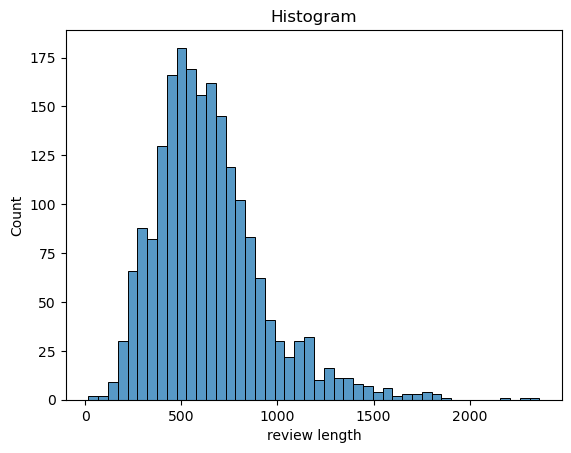

In [11]:
sns.histplot(final_df['review length'])
plt.title('Histogram')

The histogram is slightly skewed towards the right.

vii. To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to represent text using popularity/ rank of words in text. The most common word in the text will be represented as 1, the second most common word will be
 represented as 2, etc. Tokenize each text document using this method.

Tokenizing the train and test sets for top 5000 words

In [12]:
tokn = Tokenizer(num_words = 5000)
tokn.fit_on_texts(final_df['text'])
se = tokn.texts_to_sequences(final_df['text'])

viii. Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [13]:
L_val = int(np.percentile(final_df['review length'], 70))
print(f'Threshold value for review length at 70%: {L_val}')
L_temp = int(np.percentile(final_df['review length'], 90))
print(f'Threshold value for review length at 90%: {L_temp}')

Threshold value for review length at 70%: 737
Threshold value for review length at 90%: 993


I will be using L at 70% threshold for subsequent steps.

ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

I have chosen padding = post

In [87]:
pd_list = pad_sequences(se, padding='pre', truncating='post', maxlen = L_val)

In [88]:
X_train = pd_list[:1400]
y_train = train_df['label']
X_test = pd_list[1400:]
y_test = test_df['label']

## Word Embeddings

<b>Referenced from [23 - 24]</b>

In [89]:
we_model = Sequential()
we_model.add(Embedding(5000, 32, input_length =L_val))
we_model.add(Flatten())

ip_x_train_em = we_model.predict(X_train)
ip_x_test_em = we_model.predict(X_test)

D:\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [90]:
print(ip_x_train_em)

[[-0.00466231 -0.00699896  0.00821758 ...  0.03204398  0.00808956
  -0.01007963]
 [-0.02527197 -0.02592266  0.0234389  ...  0.00555962  0.01751277
  -0.00413533]
 [-0.00466231 -0.00699896  0.00821758 ...  0.01457539 -0.01895883
   0.02367387]
 ...
 [ 0.01405472  0.02898509 -0.03452066 ... -0.00134988  0.00464506
  -0.049989  ]
 [-0.00466231 -0.00699896  0.00821758 ...  0.01491498  0.00384467
  -0.02321517]
 [-0.00466231 -0.00699896  0.00821758 ...  0.04571695  0.00884359
   0.03458077]]


In [91]:
print(ip_x_test_em)

[[-0.03998373  0.01938257 -0.00822104 ...  0.02638685 -0.03851936
   0.00734724]
 [-0.02921168 -0.03806461  0.00430651 ... -0.04629165  0.00493003
  -0.04220878]
 [-0.00466231 -0.00699896  0.00821758 ...  0.03314951  0.00451306
   0.03302195]
 ...
 [-0.00466231 -0.00699896  0.00821758 ...  0.03611746  0.02853684
  -0.01493963]
 [ 0.00478754  0.01070511  0.04007572 ... -0.04387065  0.01985922
   0.01671561]
 [ 0.00277699  0.02106814 -0.00412542 ... -0.02551821  0.04882187
  -0.02089449]]


## Multi Layer Perceptron

<b>Referenced from [25 - 27]</b>

In [95]:
multi_md = Sequential()
multi_md.add(Embedding(input_dim=5000, output_dim=32, input_length=L_val))
multi_md.add(Flatten())
multi_md.add(Dense(50, activation='relu'))
multi_md.add(Dropout(0.2))
multi_md.add(Dense(50, activation='relu'))
multi_md.add(Dropout(0.5))
multi_md.add(Dense(50, activation='relu'))
multi_md.add(Dropout(0.5))
multi_md.add(Dense(1, activation='sigmoid'))

multi_md.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

multi_md.fit(X_train, y_train, epochs=2, batch_size=10, validation_data=(X_test, y_test))

_, train_acc = multi_md.evaluate(X_train, y_train)
_, test_acc = multi_md.evaluate(X_test, y_test)
print(f"Training Accuracy: {train_acc}")
print(f"Testing Accuracy: {test_acc}")

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5081 - loss: 0.7013 - val_accuracy: 0.5667 - val_loss: 0.6867
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6074 - loss: 0.6521 - val_accuracy: 0.6417 - val_loss: 0.6309
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9150 - loss: 0.2613
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6732 - loss: 0.6025 
Training Accuracy: 0.9164285659790039
Testing Accuracy: 0.6416666507720947


## 1D CNN

<b>Referenced from [28]</b>

In [99]:
conv_1d_model = Sequential()
conv_1d_model.add(Embedding(input_dim=5000, output_dim=32, input_length=L_val))
conv_1d_model.add(Conv1D(kernel_size=3, filters=32, activation='relu'))
conv_1d_model.add(MaxPooling1D(pool_size=2, strides=2))
conv_1d_model.add(Flatten())
conv_1d_model.add(Dense(50, activation='relu'))
conv_1d_model.add(Dropout(0.2))
conv_1d_model.add(Dense(50, activation='relu'))
conv_1d_model.add(Dropout(0.5))
conv_1d_model.add(Dense(50, activation='relu'))
conv_1d_model.add(Dropout(0.5))
conv_1d_model.add(Dense(1, activation='sigmoid'))

conv_1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
conv_1d_model.fit(X_train, y_train, epochs=2, batch_size=10, validation_data=(X_test, y_test))

_, train_acc = conv_1d_model.evaluate(X_train, y_train)
_, test_acc = conv_1d_model.evaluate(X_test, y_test)

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5211 - loss: 0.6989 - val_accuracy: 0.4983 - val_loss: 0.6923
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5059 - loss: 0.6940 - val_accuracy: 0.5450 - val_loss: 0.6925
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6338 - loss: 0.6908
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5422 - loss: 0.6925
Train Accuracy: 0.6278571486473083
Test Accuracy: 0.5450000166893005


## LSTM

<b>Referenced from [29 - 30]</b>

In [92]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=32, input_length=L_val))
model_lstm.add(LSTM(32, dropout=0.2))
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

_, train_accuracy = model_lstm.evaluate(X_train, y_train)
_, test_accuracy = model_lstm.evaluate(X_test, y_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.5202 - loss: 0.6921 - val_accuracy: 0.5900 - val_loss: 0.6710
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.7667 - loss: 0.5398 - val_accuracy: 0.7267 - val_loss: 0.5956
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9252 - loss: 0.1992 - val_accuracy: 0.7183 - val_loss: 0.6787
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9707 - loss: 0.0943 - val_accuracy: 0.7133 - val_loss: 0.9005
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9875 - loss: 0.0342 - val_accuracy: 0.6900 - val_loss: 1.0238
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.9947 - loss: 0.0247 - val_accuracy: 0.7200 - val_loss: 1.2346
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.9938 - loss: 0.0191 - val_accuracy: 0.6750 - val_loss: 1.0593
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9954 - loss: 0

## Additional

In this section, I have tried out with padding = post. Following is the code

### Padding

In [22]:
pd_list = pad_sequences(se, padding='post', truncating='post', maxlen = L_val)

In [23]:
X_train = pd_list[:1400]
y_train = train_df['label']
X_test = pd_list[1400:]
y_test = test_df['label']

In [24]:
we_model = Sequential()
we_model.add(Embedding(5000, 32, input_length =L_val))
we_model.add(Flatten())

ip_x_train_em = we_model.predict(X_train)
ip_x_test_em = we_model.predict(X_test)

D:\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### MLP

In [29]:

multi_md = Sequential()
multi_md.add(Embedding(input_dim=5000, output_dim=32, input_length=L_val))
multi_md.add(Flatten())
multi_md.add(Dense(50, activation='relu'))
multi_md.add(Dropout(0.2))
multi_md.add(Dense(50, activation='relu'))
multi_md.add(Dropout(0.5))
multi_md.add(Dense(50, activation='relu'))
multi_md.add(Dropout(0.5))
multi_md.add(Dense(1, activation='sigmoid'))

multi_md.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

multi_md.fit(X_train, y_train, epochs=2, batch_size=10, validation_data=(X_test, y_test))

_, train_acc = multi_md.evaluate(X_train, y_train)
_, test_acc = multi_md.evaluate(X_test, y_test)
print(f"Training Accuracy: {train_acc}")
print(f"Testing Accuracy: {test_acc}")

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5293 - loss: 0.7035 - val_accuracy: 0.5417 - val_loss: 0.6873
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5504 - loss: 0.6832 - val_accuracy: 0.6267 - val_loss: 0.6634
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8132 - loss: 0.5415
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6460 - loss: 0.6598 
Training Accuracy: 0.8100000023841858
Testing Accuracy: 0.6266666650772095


### CNN

In [55]:
conv_1d_model = Sequential()
conv_1d_model.add(Embedding(input_dim=5000, output_dim=32, input_length=L_val))
conv_1d_model.add(Conv1D(kernel_size=3, filters=32, activation='relu'))
conv_1d_model.add(MaxPooling1D(pool_size=2, strides=2))
conv_1d_model.add(Flatten())
conv_1d_model.add(Dense(50, activation='relu'))
conv_1d_model.add(Dropout(0.2))
conv_1d_model.add(Dense(50, activation='relu'))
conv_1d_model.add(Dropout(0.5))
conv_1d_model.add(Dense(50, activation='relu'))
conv_1d_model.add(Dropout(0.5))
conv_1d_model.add(Dense(1, activation='sigmoid'))

conv_1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
conv_1d_model.fit(X_train, y_train, epochs=2, batch_size=10, validation_data=(X_test, y_test))

_, train_acc = conv_1d_model.evaluate(X_train, y_train)
_, test_acc = conv_1d_model.evaluate(X_test, y_test)

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4712 - loss: 0.6992 - val_accuracy: 0.5317 - val_loss: 0.6929
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5571 - loss: 0.6876 - val_accuracy: 0.6017 - val_loss: 0.6876
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7206 - loss: 0.6758
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5890 - loss: 0.6875
Train Accuracy: 0.7300000190734863
Test Accuracy: 0.6016666889190674


### LSTM

In [71]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=32, input_length=L_val))
model_lstm.add(LSTM(32, dropout=0.2))
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

_, train_accuracy = model_lstm.evaluate(X_train, y_train)
_, test_accuracy = model_lstm.evaluate(X_test, y_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.5096 - loss: 0.6940 - val_accuracy: 0.5383 - val_loss: 0.6906
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.5342 - loss: 0.6915 - val_accuracy: 0.5350 - val_loss: 0.6893
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.5383 - loss: 0.6663 - val_accuracy: 0.5383 - val_loss: 0.7069
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.5924 - loss: 0.6190 - val_accuracy: 0.5200 - val_loss: 0.7028
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.6248 - loss: 0.6059 - val_accuracy: 0.5017 - val_loss: 0.8182
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.6153 - loss: 0.5885 - val_accuracy: 0.5400 - val_loss: 0.8710
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.5943 - loss: 0.5748 - val_accuracy: 0.5267 - val_loss: 0.8137
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.5846 - loss: 0

## Conclusions

Following are my observations:

<ul><li>When padding is set to pre, LSTM has the highest testing accuracy (69%) followed by MLP (64%) and 1D CNN (54.5%). Besides the training accuracy for LSTM is nearly 100%.</li>
    <li>When padding is set to post, MLP has the highest testing accuracy (62%) followed by 1D CNN (60%) and LSTM (54.5%). Also, MLP has the highest training accuracy of 81%.</li>
    <li>Additionally, we can perform hyperparameter tuning to obtain the best parameters.</li>
</ul>

## References

[1] https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html<br>
[2] https://docs.python.org/3/library/os.html#os.listdir<br>
[3] https://www.geeksforgeeks.org/python-os-path-join-method/<br>
[4] https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas<br>
[5] https://stackoverflow.com/questions/41719259/how-to-remove-numbers-from-string-terms-in-a-pandas-dataframe<br>
[6] https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html<br>
[7] https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html<br>
[8] https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html<br>
[9] https://www.geeksforgeeks.org/how-to-convert-pandas-dataframe-into-a-list/<br>
[10] https://www.w3schools.com/python/ref_string_join.asp<br>
[11] https://www.nltk.org/api/nltk.tokenize.html<br>
[12] https://stackoverflow.com/questions/49215099/get-length-of-values-in-pandas-dataframe-column<br>
[13] https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html<br>
[14] https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html<br>
[15] https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html<br>
[16] https://seaborn.pydata.org/generated/seaborn.histplot.html<br>
[17] https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer<br>
[18] https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do<br>
[19] https://medium.com/analytics-vidhya/understanding-nlp-keras-tokenizer-class-arguments-with-example-551c100f0cbd<br>
[20] https://numpy.org/doc/stable/reference/generated/numpy.percentile.html<br>
[21] https://hatchjs.com/from-keras-preprocessing-sequence-import-pad_sequences/<br>
[22] https://stackoverflow.com/questions/42943291/what-does-keras-io-preprocessing-sequence-pad-sequences-do<br>
[23] https://keras.io/api/layers/core_layers/embedding/<br>
[24] https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras<br>
[25] https://keras.io/api/layers/core_layers/dense/<br>
[26] https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/<br>
[27] https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/<br>
[28] https://stackoverflow.com/questions/53696541/how-to-use-maxpooling1d-with-conv1d<br>
[29] https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/<br>
[30] https://keras.io/api/layers/recurrent_layers/lstm/<br>